# Bi-level optimization for Sliced Wasserstein with Generalized Geodesics (SWGG)

Let us define

$$
    F(\theta) = \left\langle C_{xy}, \pi^\star(\theta) \right\rangle
$$

where

$$
    \pi^\star(\theta) = \arg \min_\pi \left\langle C_{xy}^\theta, \pi \right\rangle  .
$$

Our goal would be to minimize $F(\theta)$.

Similar to [Berthet et al][1], we can define

$$
    F_\varepsilon(\theta) = E_{\omega \thicksim p_{\theta, \varepsilon}} \left[ \left\langle C_{xy}, \pi^\star(\omega) \right\rangle \right] .
$$

In order to minimize $F_\varepsilon(\theta)$ through gradient descent, we would like to compute

$$
    \nabla_\theta F_\varepsilon
        = \nabla_\theta E_{\omega \thicksim p_{\theta, \varepsilon}} \left[ F(\omega) \right]  .
$$

The derivative of the expectation can be computed using [Stein's Lemma (Section 14.4.3)][2] that gives, in the case of a Gaussian distribution:

$$
    \nabla_\theta F_\varepsilon = E_{z \thicksim p_{0, 1}} \left[ F(\theta + \varepsilon z) \cdot \frac{z}{\varepsilon} \right]
$$

which can be estimated using Monte-Carlo sampling.

[1]: https://arxiv.org/pdf/2002.08676
[2]: https://arxiv.org/abs/2403.14606

In [1]:
import numpy as np
import torch

n = 100
d = 2
n_outliers = 0
np.random.seed(10)
torch.manual_seed(10)

x = np.random.randn(n, d) * 3
y = np.random.randn(n, d)
x[:, 1] /= 10
y[:, 1] /= 10

In [2]:
from perturbed_sliced import PerturbedPartialSWGG, swgg_step, compute_cost

def compute_stuff(x, y, n_angles, n_samples, sigma, plot_grads, n_steps_gradient=None):
    list_theta = torch.linspace(-np.pi, np.pi, n_angles)

    all_F = []
    all_F_epsilon = []
    if plot_grads:
        all_grad_F_epsilon = []
    else:
        all_grad_F_epsilon = None
    for i, theta in enumerate(list_theta):
        # print(min(list_theta), theta, max(list_theta))
        theta.requires_grad_(True)
        w = torch.stack([torch.cos(theta), torch.sin(theta)])
        w.requires_grad_(True)

        # Cost
        cost = compute_cost(x, y, w.detach().numpy(), n - n_outliers)
        all_F.append(cost)

        F_epsilon = swgg_step(w, x, y, n-n_outliers, n_samples, "normal", sigma, "cpu")
        all_F_epsilon.append(F_epsilon.detach().numpy())

        if i % 10 == 0 and plot_grads:
            F_epsilon.backward()
            all_grad_F_epsilon.append(np.copy(theta.grad.detach().numpy()))
    
    if n_steps_gradient is not None:
        sliced = PerturbedPartialSWGG(max_iter_gradient=n_steps_gradient, 
                                    max_iter_partial=n-n_outliers, 
                                    perturbation_n_samples=n_samples,
                                    perturbation_sigma=sigma,
                                    opt_lambda_fun=lambda param: torch.optim.SGD(param, lr=1e-1, momentum=.9))
        sliced.fit(x, y)
    else:
        sliced = None
            
    return all_F, all_F_epsilon, all_grad_F_epsilon, sliced

In [3]:
import matplotlib.pyplot as plt

def plot_F_theta_1d(n_angles, all_F, all_F_epsilon, all_grad_F_epsilon=None, sliced=None):
    list_theta = torch.linspace(-np.pi, np.pi, n_angles)
    plt.plot(list_theta.detach().numpy(), all_F, label="$F(\\theta)$")
    plt.plot(list_theta.detach().numpy(), all_F_epsilon, label="$F_\\varepsilon(\\theta)$")
    if all_grad_F_epsilon is not None:
        for i, theta in enumerate(list_theta):
            if i % 10 != 0:
                continue
            epsilon=.3
            grad = all_grad_F_epsilon[i // 10]
            plt.plot([theta - epsilon, theta + epsilon], 
                    [all_F[i] - epsilon * grad, all_F[i] + epsilon * grad], 
                    color="r")


    if sliced is not None:
        list_w = sliced.list_w_
        list_w_grad = sliced.list_w_grad_
        for i, ((w_x, w_y), (dx, dy)) in enumerate(zip(list_w, list_w_grad)):
            theta = np.arctan2(w_y, w_x)
            w = torch.Tensor([w_x, w_y])

            # Cost
            cost = compute_cost(x, y, w.detach().numpy(), n - n_outliers)
            plt.plot([theta], [cost], color="r", marker="o")
            plt.annotate(str(i + 1), [theta, cost])

            if all_grad_F_epsilon is not None:
                epsilon = .3
                normal = np.array([-np.sin(theta), np.cos(theta)])
                grad = np.array([dx, dy]) @ normal
                print(w_x, w_y, theta, dx, dy, grad)
                plt.plot([theta - epsilon, theta + epsilon], 
                        [cost - epsilon * grad, cost + epsilon * grad], 
                        color="r")
        
    plt.ylabel("OT cost")
    plt.xlabel("$\\theta$")
    plt.legend()
    plt.title(f"Estimating $F(\\theta)$ in 1D")
    plt.show()

/Users/rtavenar/Documents/recherche/src/bilevel_swgg/perturbed_sliced.py:47: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3701.)
  proj_x = (w @ x.T).T


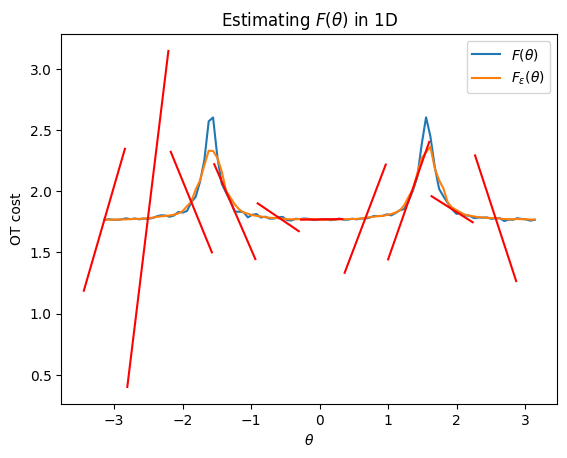

In [4]:
n_angles = 100

F, F_epsilon, grad_F_epsilon, sliced = compute_stuff(x, y, n_angles=n_angles, n_samples=100, sigma=.1, 
                                                     plot_grads=True, n_steps_gradient=None)
plot_F_theta_1d(n_angles, F, F_epsilon, grad_F_epsilon, sliced)


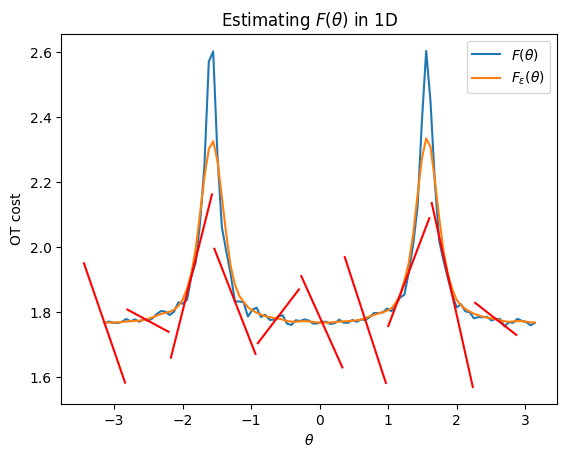

In [5]:
F, F_epsilon, grad_F_epsilon, sliced = compute_stuff(x, y, n_angles=n_angles, n_samples=1000, sigma=.1, 
                                                     plot_grads=True, n_steps_gradient=None)
plot_F_theta_1d(n_angles, F, F_epsilon, grad_F_epsilon, sliced)
